# Task-1: Training an autoencoder as a 2D feature generator and displaying CIFAR10 dataset's features.

# Importing necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose, GlobalAveragePooling2D

# Load and preprocess the CIFAR-10 dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# Building the autoencoder model

In [3]:
LATENT_DIM = 2

input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(input_img) # 16x16
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 8x8
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x) # 4x4

shape_before_flattening = tf.keras.backend.int_shape(x)
x = Flatten()(x)
latent_vector = Dense(LATENT_DIM, name='latent_space')(x)

encoder = Model(input_img, latent_vector, name='encoder')
encoder.summary()

latent_input = Input(shape=(LATENT_DIM,))

x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_input)
x = Reshape(shape_before_flattening[1:])(x)

x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2)(x) # 8x8
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 16x16
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x) # 32x32

decoded_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(latent_input, decoded_output, name='decoder')
decoder.summary()

autoencoder_input = Input(shape=(32, 32, 3), name='autoencoder_input')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = Model(autoencoder_input, decoded_img, name='autoencoder')
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,346 (380.26 KB)

 Trainable params: 97,346 (380.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        97,346 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 3)      │       246,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,197 (1.31 MB)

 Trainable params: 344,197 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and train the autoencoder

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - loss: 0.0471 - val_loss: 0.0371
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0369 - val_loss: 0.0369
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0368 - val_loss: 0.0368
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0367 - val_loss: 0.0366
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0366 - val_loss: 0.0366
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0365 - val_loss: 0.0365
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0364 - val_loss: 0.0365
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0363 - val_loss: 0.0366
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0364 - val_loss: 0.0364
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0365 - val_loss: 0.0364
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━

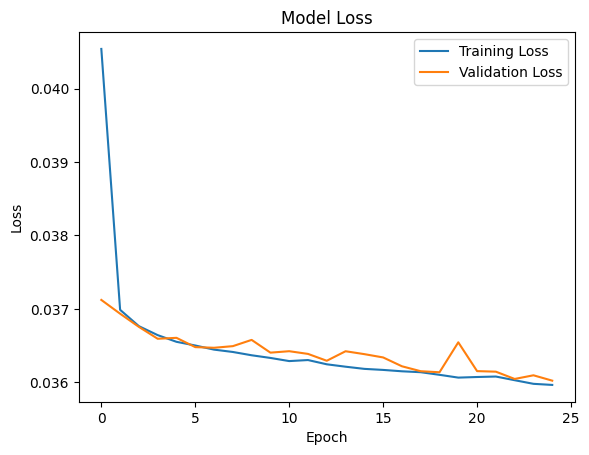

In [4]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualizing reconstructed images

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


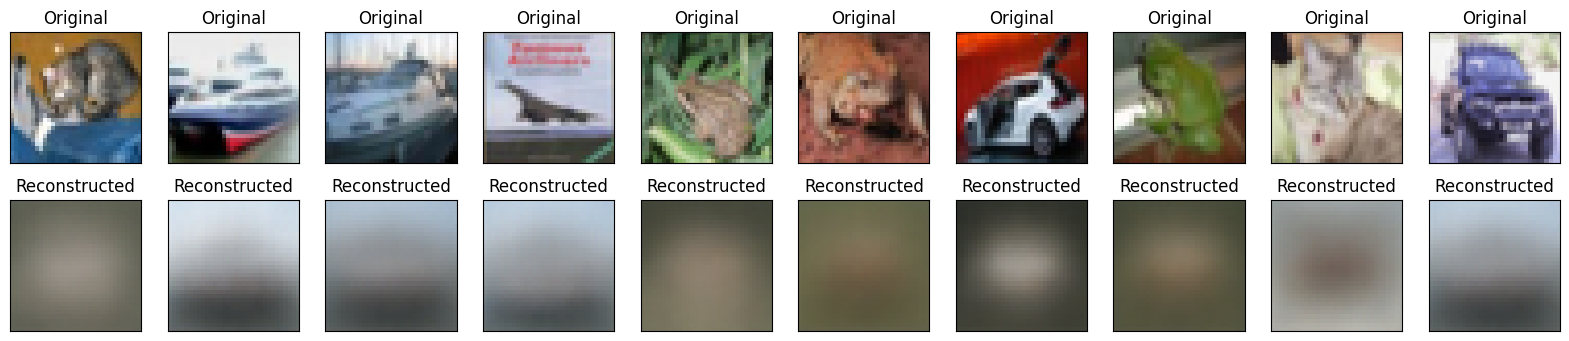

In [5]:
reconstructed_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i])
    plt.title("Reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generating and displaying the 2D features

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


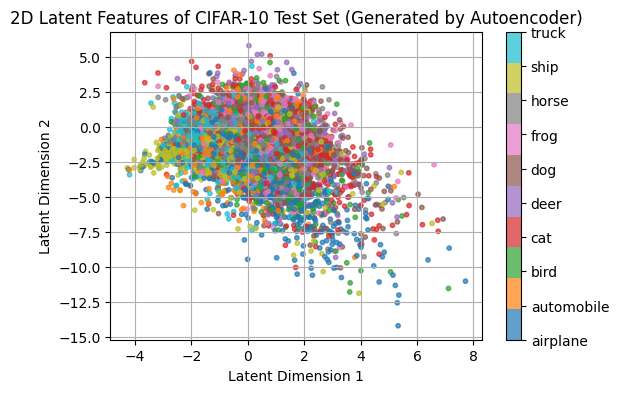

In [6]:
latent_features = encoder.predict(x_test)

plt.figure(figsize=(6, 4))
scatter = plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test_flat,
                      alpha=0.7, s=10, cmap='tab10')

cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
plt.title('2D Latent Features of CIFAR-10 Test Set (Generated by Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

# Task-2: Comparing autoencoder generated features with features extracted by a pre-trained CNN and reduced by dimension reduction techniques like PCA, t-SNE.

# Load VGG-16 and extract high-dimensional features

In [7]:
vgg16_base = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

print("Setting layer trainability...")
for i, layer in enumerate(vgg16_base.layers):
    if i < len(vgg16_base.layers) - 10:
        layer.trainable = False
    else:
        layer.trainable = True
    print(f"Layer {layer.name}: Trainable = {layer.trainable}")

vgg16_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Setting layer trainability...
Layer input_layer_2: Trainable = False
Layer block1_conv1: Trainable = False
Layer block1_conv2: Trainable = False
Layer block1_pool: Trainable = False
Layer block2_conv1: Trainable = False
Layer block2_conv2: Trainable = False
Layer block2_pool: Trainable = False
Layer block3_conv1: Trainable = False
Layer block3_conv2: Trainable = False
Layer block3_conv3: Trainable = True
Layer block3_pool: Trainable = True
Layer block4_conv1: Trainable = True
Layer block4_conv2: Trainable = True
Layer block4_conv3: Trainable = True
Layer block4_pool: Trainable = True
Layer block5_conv1: Trainable = True
Layer block5_conv2: Trainable = True
Layer block5_conv3: Trainable = True
Layer block5_pool: Trainable = True


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

# Create and Fine-Tune the Model on CIFAR-10

In [8]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = vgg16_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10)(x)
fine_tune_model = tf.keras.Model(inputs, outputs)

fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

fine_tune_model.summary()

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_test_flat = y_test.flatten()

print("\nStarting fine-tuning...")
history_finetune = fine_tune_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test)
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 13,574,410 (51.78 MB)

 Non-trainable params: 1,145,408 (4.37 MB)


Starting fine-tuning...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.5211 - loss: 1.3568 - val_accuracy: 0.7264 - val_loss: 0.7799
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.7534 - loss: 0.7032 - val_accuracy: 0.7633 - val_loss: 0.6727
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.7987 - loss: 0.5791 - val_accuracy: 0.7766 - val_loss: 0.6399
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8237 - loss: 0.5016 - val_accuracy: 0.7830 - val_loss: 0.6352
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8503 - loss: 0.4275 - val_accuracy: 0.7801 - val_loss: 0.6332
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy: 0.8722 - loss: 0.3689 - val_accuracy: 0.7867 - val_loss: 0.6309
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.8906 - loss: 0.3169 - val_accuracy: 0.7976 - val_loss: 0.6271
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - accuracy:

# Apply PCA and t-SNE for Dimensionality Reduction

In [9]:
tuned_vgg_layer = fine_tune_model.get_layer('vgg16')

print("Extracting fine-tuned features using the updated layer...")
vgg_features_tuned = tuned_vgg_layer.predict(x_test)

vgg_features_tuned_flat = vgg_features_tuned.reshape(vgg_features_tuned.shape[0], -1)
print("Shape of fine-tuned features:", vgg_features_tuned_flat.shape)

print("\nApplying PCA to reduce dimensions to 2...")
pca_tuned = PCA(n_components=2)
pca_features_tuned = pca_tuned.fit_transform(vgg_features_tuned_flat)
print("PCA features shape:", pca_features_tuned.shape)

print("\nApplying t-SNE on all 10,000 samples. This may take a while...")
tsne_tuned = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=500, random_state=42)
tsne_features_tuned = tsne_tuned.fit_transform(vgg_features_tuned_flat)
print("t-SNE features shape:", tsne_features_tuned.shape)

Extracting fine-tuned features using the updated layer...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
Shape of fine-tuned features: (10000, 512)

Applying PCA to reduce dimensions to 2...
PCA features shape: (10000, 2)

Applying t-SNE on all 10,000 samples. This may take a while...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 3.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilit

# Visualize and Compare All Three Feature Sets

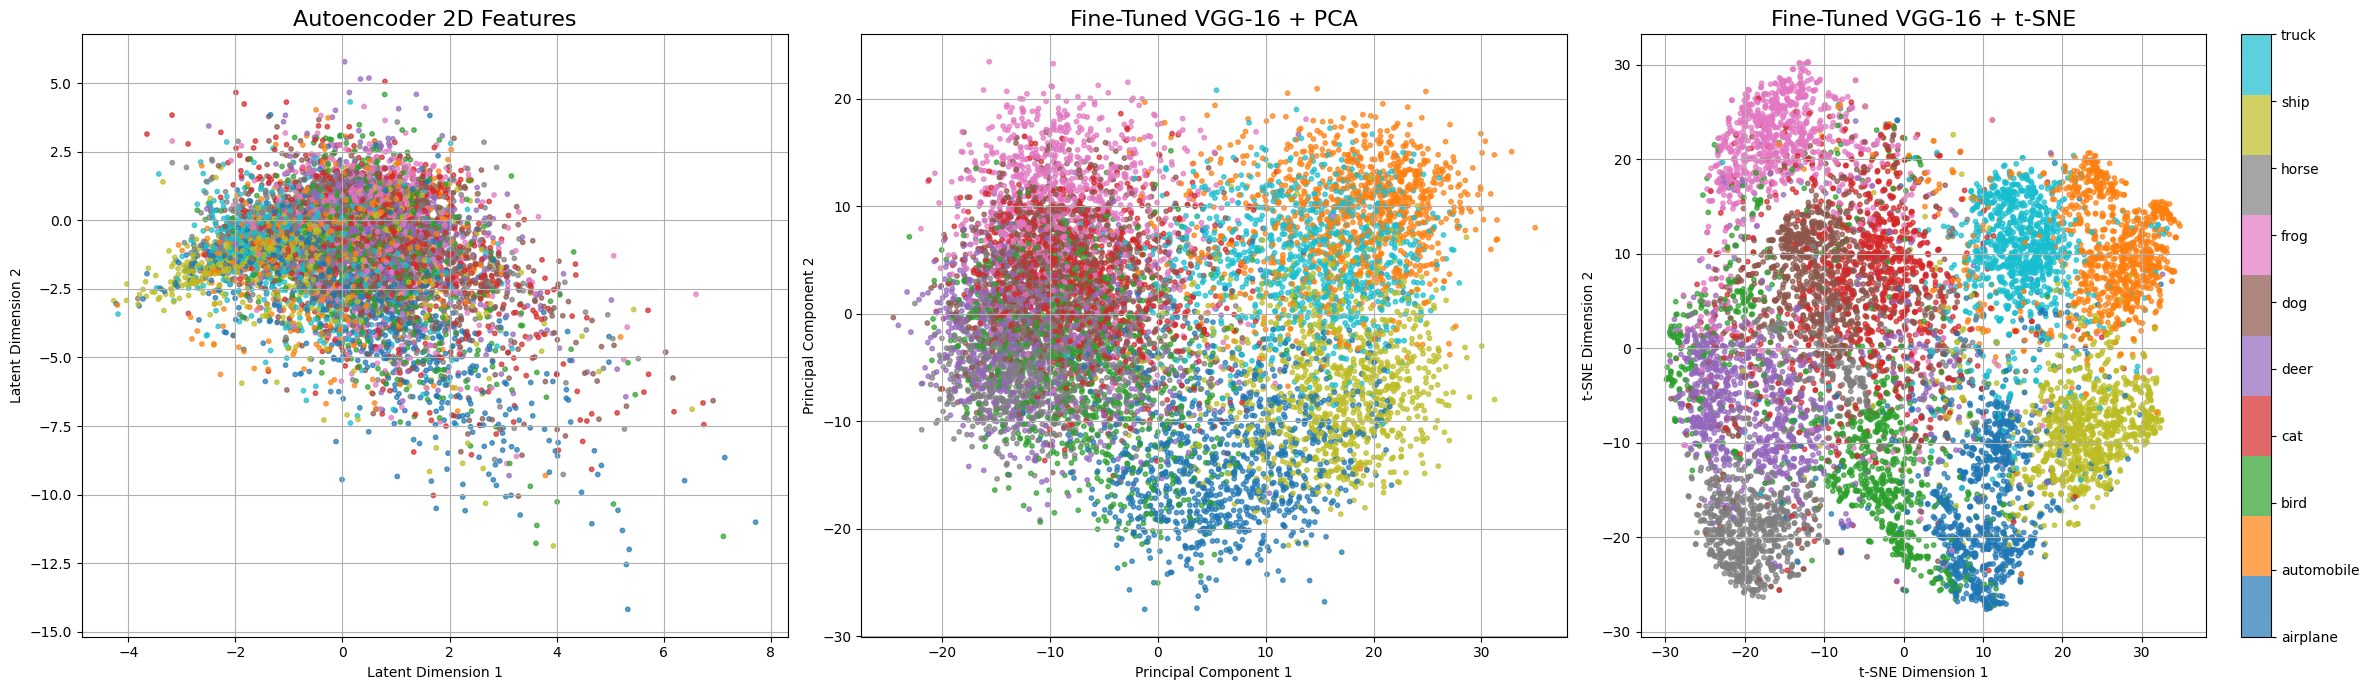

In [10]:
plt.figure(figsize=(24, 7))

plt.subplot(1, 3, 1)
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y_test_flat,
            alpha=0.7, s=10, cmap='tab10')
plt.title('Autoencoder 2D Features', fontsize=16)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(pca_features_tuned[:, 0], pca_features_tuned[:, 1], c=y_test_flat,
            alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + PCA', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

ax3 = plt.subplot(1, 3, 3)
scatter = ax3.scatter(tsne_features_tuned[:, 0], tsne_features_tuned[:, 1], c=y_test_flat,
                      alpha=0.7, s=10, cmap='tab10')
plt.title('Fine-Tuned VGG-16 + t-SNE', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

cbar = plt.colorbar(scatter, ax=ax3, ticks=range(10))
cbar.ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

# Task-3: Training a denoising autoencoder for CIFAR10 dataset.

# Adding Noise to the Images

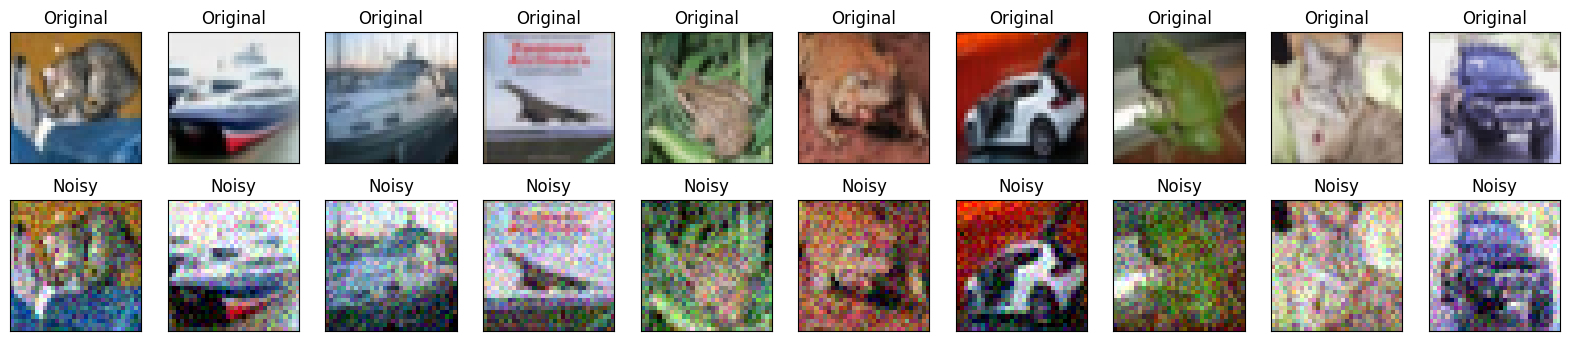

In [11]:
noise_factor = 0.1

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Building the Denoising Autoencoder Model

In [12]:
input_img = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x) # 16x16
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x) # 8x8
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) # 4x4 - This is the bottleneck

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x) # 8x8
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 16x16
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 32x32
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,507 (584.01 KB)

 Trainable params: 149,507 (584.01 KB)

 Non-trainable params: 0 (0.00 B)

# Compile and Train the denoising autoencoder

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0260 - val_loss: 0.0116
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0114 - val_loss: 0.0100
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━

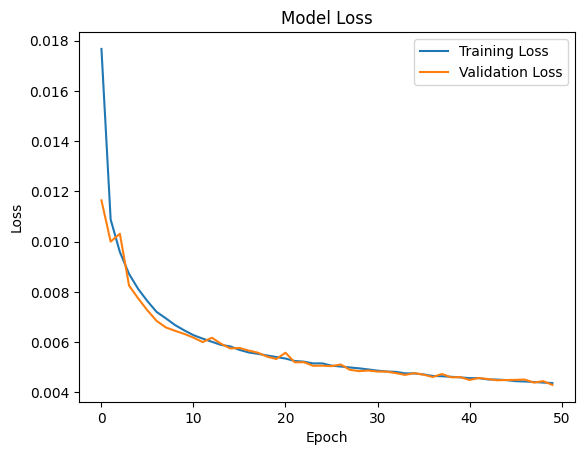

In [13]:
denoising_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = denoising_autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Visualize the denoised images

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


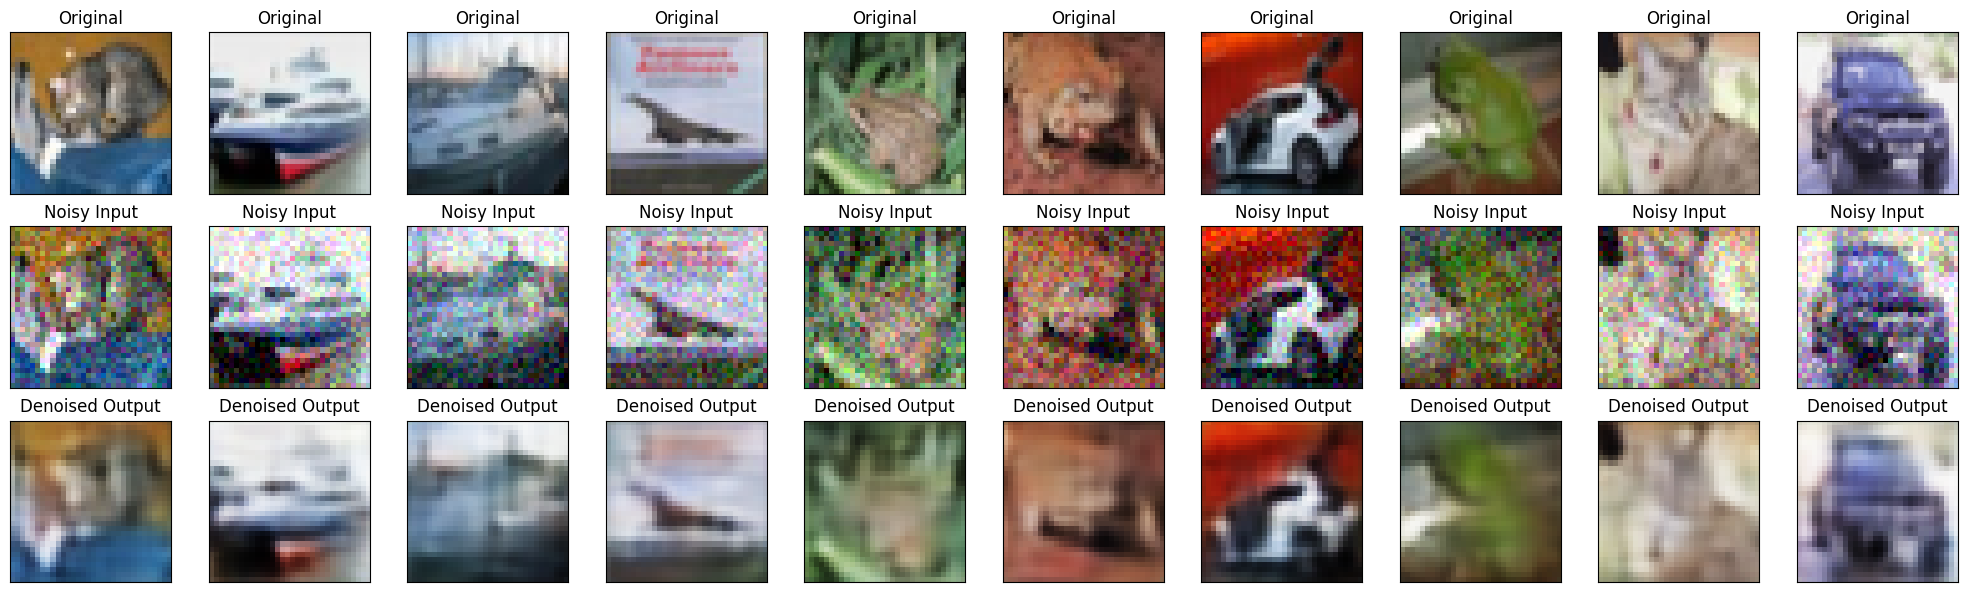

In [14]:
denoised_images = denoising_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy Input")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i])
    plt.title("Denoised Output")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# Task-4: Training a CNN based CIFAR-10 classifier without any single-image data augmentation techniques.

# Build the VGG-16 based classifier

In [15]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

vgg_base.trainable = True
print(f"Number of layers in the base model: {len(vgg_base.layers)}")
print("All layers in the VGG16 base are now trainable.")

inputs = Input(shape=(32, 32, 3))
x = vgg_base(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(10)(x)

classifier_model = Model(inputs, outputs)

classifier_model.summary()

Number of layers in the base model: 19
All layers in the VGG16 base are now trainable.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 14,848,586 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

#

# Compile the model

In [16]:
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Model compiled successfully.")

Model compiled successfully.


#

# Imports and Constants

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import gc

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 40
IMAGE_SIZE = (32, 32, 3)
NUM_CLASSES = 10

# Data Preparation (Train / Validation / Test Split)

In [18]:
(x_full_train, y_full_train), (x_test, y_test) = cifar10.load_data()

x_full_train = x_full_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train, x_val, y_train, y_val = train_test_split(
    x_full_train, y_full_train, test_size=0.2, random_state=42
)

y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()

print(f"Training set shape:   {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape:       {x_test.shape}")

Training set shape:   (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape:       (10000, 32, 32, 3)


# Create Data Pipelines

In [19]:
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ],
    name="data_augmentation",
)

train_ds_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_aug = train_ds_aug.shuffle(buffer_size=len(x_train))
train_ds_aug = train_ds_aug.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds_aug = train_ds_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds_no_aug = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds_no_aug = train_ds_no_aug.shuffle(buffer_size=len(x_train))
train_ds_no_aug = train_ds_no_aug.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Data pipelines created.")

Data pipelines created.


# Visualize the augmented images

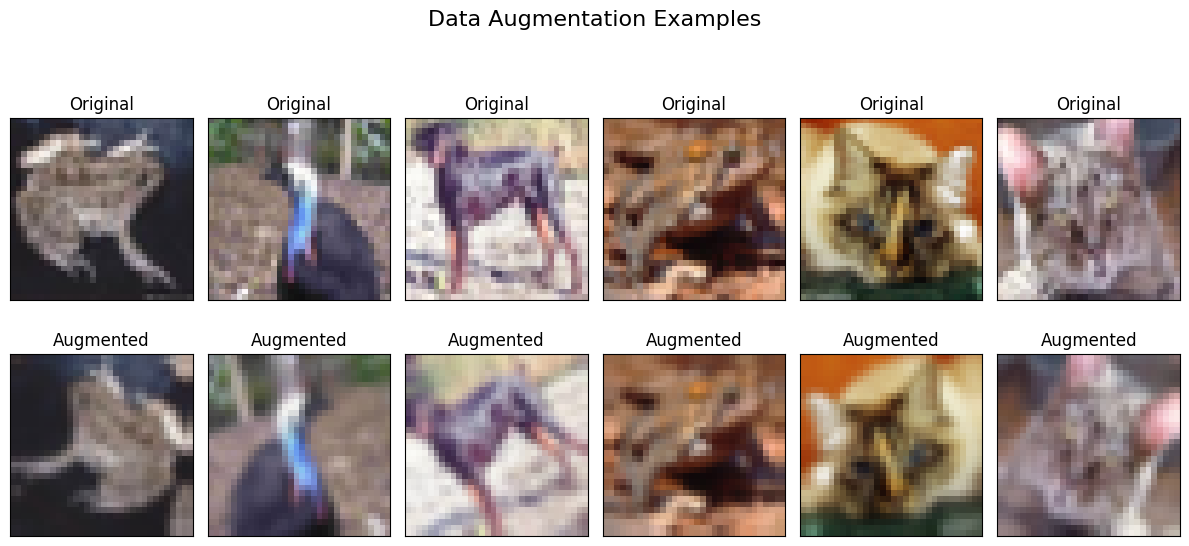

In [20]:

sample_images = x_train[:6]
augmented_images_list = []
for image in sample_images:
    augmented_image = data_augmentation(image)
    augmented_images_list.append(augmented_image)

augmented_images = np.array(augmented_images_list)

plt.figure(figsize=(12, 6))
plt.suptitle("Data Augmentation Examples", fontsize=16)

for i in range(6):
    ax = plt.subplot(2, 6, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 6, i + 1 + 6)
    plt.imshow(np.clip(augmented_images[i], 0, 1))
    plt.title("Augmented")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Model Building Function

In [21]:
def build_classifier_model():

    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg_base.trainable = True

    inputs = Input(shape=(32, 32, 3))
    x = vgg_base(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10)(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

print("Model builder function defined.")

Model builder function defined.


# Train Model WITHOUT Augmentation

In [22]:
print("--- Training Model WITHOUT Data Augmentation ---")
model_no_aug = build_classifier_model()

history_no_aug = model_no_aug.fit(
    train_ds_no_aug,
    epochs=30,
    validation_data=val_ds,
    verbose=1
)

--- Training Model WITHOUT Data Augmentation ---
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.4921 - loss: 1.4384 - val_accuracy: 0.7405 - val_loss: 0.7596
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.7559 - loss: 0.6977 - val_accuracy: 0.7753 - val_loss: 0.6619
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.8012 - loss: 0.5734 - val_accuracy: 0.7861 - val_loss: 0.6302
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8294 - loss: 0.4912 - val_accuracy: 0.8112 - val_loss: 0.5486
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8557 - loss: 0.4128 - val_accuracy: 0.8078 - val_loss: 0.5693
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8709 - loss: 0.3664 - val_accuracy: 0.8087 - val_loss: 0.5651
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.8920 - loss: 0.3075 - val_accuracy: 0.8248 - val_loss: 0.5265
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4

# Task-5: Training a CNN based CIFAR-10 classifier with a single/multiple single-image data augmentation techniques.

# Train Model WITH Augmentation

In [23]:
print("\n--- Training Model WITH Data Augmentation ---")
model_with_aug = build_classifier_model()

history_with_aug = model_with_aug.fit(
    train_ds_aug,
    epochs=30,
    validation_data=val_ds,
    verbose=1
)


--- Training Model WITH Data Augmentation ---
Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 105ms/step - accuracy: 0.4375 - loss: 1.5746 - val_accuracy: 0.6649 - val_loss: 0.9537
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 103ms/step - accuracy: 0.6747 - loss: 0.9225 - val_accuracy: 0.7368 - val_loss: 0.7654
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 103ms/step - accuracy: 0.7161 - loss: 0.8045 - val_accuracy: 0.7557 - val_loss: 0.7080
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.7428 - loss: 0.7305 - val_accuracy: 0.7688 - val_loss: 0.6622
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 103ms/step - accuracy: 0.7565 - loss: 0.6825 - val_accuracy: 0.7701 - val_loss: 0.6662
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 103ms/step - accuracy: 0.7769 - loss: 0.6338 - val_accuracy: 0.7923 - val_loss: 0.6045
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.7888 - loss: 0.6021 - val_accuracy: 0.7949 - val_loss: 0.5978
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━

# Final Evaluation and Visualization

ValueError: x and y must have same first dimension, but have shapes (40,) and (30,)

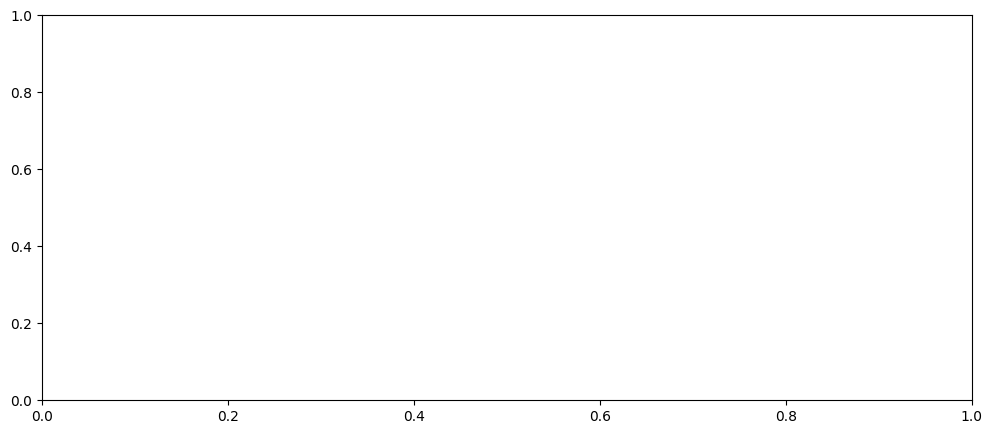

In [26]:
val_acc_no_aug = history_no_aug.history['val_accuracy']
val_acc_with_aug = history_with_aug.history['val_accuracy']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.plot(epochs_range, val_acc_no_aug, label='Validation Accuracy (No Augmentation)', color='red')
plt.plot(epochs_range, val_acc_with_aug, label='Validation Accuracy (With Augmentation)', color='blue')
plt.title('Validation Accuracy Comparison Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\nEvaluating final performance on the held-out test set...")
loss_no_aug, acc_no_aug = model_no_aug.evaluate(test_ds, verbose=0)
loss_with_aug, acc_with_aug = model_with_aug.evaluate(test_ds, verbose=0)

labels = ['Without Augmentation', 'With Augmentation']
test_accuracies = [acc_no_aug, acc_with_aug]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, test_accuracies, color=['#FF5733', '#33C4FF'])
plt.ylabel('Final Test Set Accuracy')
plt.title('Final Model Accuracy on the Test Set')
plt.ylim([0, 1.0])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=12)

plt.show()